#Prepare data

In [20]:
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
import copy
import warnings
import math
from pandas import DataFrame
import urllib.request
import tarfile


##Retrieving MR dataset

In [21]:
url = "https://www.cs.cornell.edu/people/pabo/movie-review-data/rt-polaritydata.tar.gz"
filename = "rt-polaritydata.tar.gz"

# Download the file
urllib.request.urlretrieve(url, filename)

# Open the tar.gz file in read mode
with tarfile.open('rt-polaritydata.tar.gz', 'r:gz') as tar:
    # Extract all files to a directory
    tar.extractall()

In [22]:
# Open the file in read mode
neg = []
pos = []
labels = []
with open('rt-polaritydata/rt-polarity.neg', 'r', encoding='latin-1') as file:
    # Read all lines and store them in a list
    neg = file.readlines()


with open('rt-polaritydata/rt-polarity.pos', 'r', encoding='latin-1') as file:
    # Read all lines and store them in a list
    pos = file.readlines()

data = neg + pos
labels = [0] * len(neg) + [1] * len(pos)

Preprocess data

In [23]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Define a function to preprocess text data
def preprocess_text(text: str) -> str:
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub('[^a-zA-Z]', ' ', text.lower())

    # Tokenize the text into words
    words = nltk.word_tokenize(text)

    # Remove stop words
    #words = [word for word in words if word not in stopwords.words('english')]

    # Lemmatize the remaining words
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]

    # Return the preprocessed text as a string
    return ' '.join(words)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


##Preprocessing

In [24]:
#for some reason preprocessing text lowers accuracy by 1 to 3%
#data = [preprocess_text(text) for text in data]

Randomize data

In [25]:
import numpy as np

def unison_shuffled_copies(data_array: list, labels_array: list) -> tuple[list, list]:
    assert len(data_array) == len(labels_array)
    p = np.random.permutation(len(data_array))
    return data_array[p], labels_array[p]

data, labels = unison_shuffled_copies(np.array(data) , np.array(labels))

print(data[:5], labels[:5])

['this loud and thoroughly obnoxious comedy about a pair of squabbling working-class spouses is a deeply unpleasant experience . \n'
 "the 3d images only enhance the film's otherworldly quality , giving it a strange combo of you-are-there closeness with the disorienting unreality of the seemingly broken-down fourth wall of the movie screen . \n"
 'there are films that try the patience of even the most cinema-besotted critic -- and this was one of them . \n'
 'a small gem of a movie that defies classification and is as thought-provoking as it is funny , scary and sad . \n'
 "the story and structure are well-honed . fresnadillo's dark and jolting images have a way of plying into your subconscious like the nightmare you had a week ago that won't go away . \n"] [0 1 0 1 1]


Seperate train and test set

In [26]:
from sklearn.model_selection import train_test_split

train_data, test_data, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

Plot ROC curve

In [27]:
from sklearn.metrics import roc_curve
import matplotlib.pyplot as plt

def plot_roc_curve(y_true, y_pred):
    fpr, tpr, thresholds = roc_curve(y_true, y_pred)
    plt.plot(fpr, tpr)
    plt.plot([0, 1], [0, 1], linestyle='--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic (ROC) Curve')
    plt.show()

# Try a simple logistic model

In [45]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

baseline_model = make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression(max_iter=1000)).fit(train_data, train_labels)

Batch test

In [54]:
def batch_train(model, X_train, y_train, X_test, y_test):
    # Split data into batches
  batch_size = 100
  num_batches = int(len(X_train) / batch_size)
  batches_X = np.array_split(X_train, num_batches)
  batches_y = np.array_split(y_train, num_batches)

  # Initialize Logistic Regression model
  model = LogisticRegression()

  # Train model using batch gradient descent
  for i in range(num_batches):
      model.fit(batches_X[i], batches_y[i])

  # Evaluate model
  accuracy = model.score(X_test, y_test)

In [56]:
#batch_train(make_pipeline(CountVectorizer(ngram_range=(1,3)), LogisticRegression(max_iter=1000)),train_data, test_data, train_labels, test_labels)

##Test logistic model

              precision    recall  f1-score   support

           0       0.79      0.75      0.77      1112
           1       0.74      0.78      0.76      1021

    accuracy                           0.76      2133
   macro avg       0.76      0.76      0.76      2133
weighted avg       0.76      0.76      0.76      2133

Accuracy: 0.7637130801687764


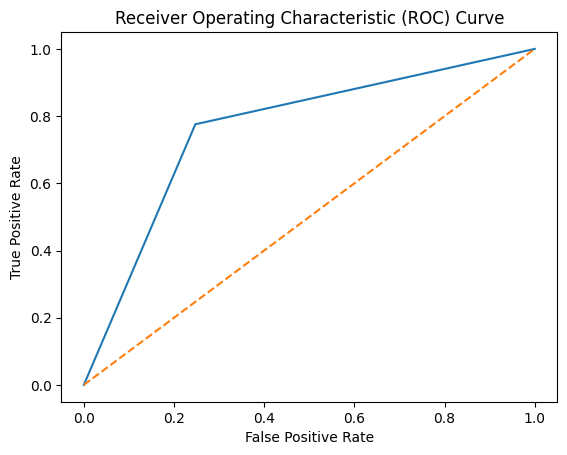

In [ ]:
baseline_predicted = baseline_model.predict(test_data)

print(classification_report(test_labels, baseline_predicted))
print("Accuracy: " + str(accuracy_score(test_labels, baseline_predicted)))

plot_roc_curve(test_labels, baseline_predicted)

##10 fold Cross Validation for Logistic Regression

In [ ]:
from sklearn.model_selection import cross_val_score

# Use 10-fold cross-validation to estimate the accuracy
scores = cross_val_score(baseline_model, data, labels, cv=10)

# Print the mean and standard deviation of the accuracy scores
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.77 (+/- 0.02)


# Basic SVM with linear kernal


In [ ]:
from sklearn import svm
from sklearn.svm import LinearSVC

svm_model = make_pipeline(TfidfVectorizer(ngram_range=(1,2)), LinearSVC(loss='squared_hinge', C=1, tol=0.1, max_iter=10000))
fitt_svm= svm_model.fit(train_data, train_labels)

## Test SVM

In [ ]:
svm_predicted = fitt_svm.predict(test_data)

print(classification_report(test_labels, svm_predicted))
print("Accuracy: " + str(accuracy_score(test_labels, svm_predicted)))

              precision    recall  f1-score   support

           0       0.81      0.75      0.78      1112
           1       0.75      0.80      0.78      1021

    accuracy                           0.78      2133
   macro avg       0.78      0.78      0.78      2133
weighted avg       0.78      0.78      0.78      2133

Accuracy: 0.7782466010314112


##10 fold Cross Validation for SVM

In [ ]:
# Use 10-fold cross-validation to estimate the accuracy
scores = cross_val_score(svm_model, data, labels, cv=10)

# Print the mean and standard deviation of the accuracy scores
print('Accuracy: %0.2f (+/- %0.2f)' % (scores.mean(), scores.std() * 2))

Accuracy: 0.79 (+/- 0.02)


Print ROC curve

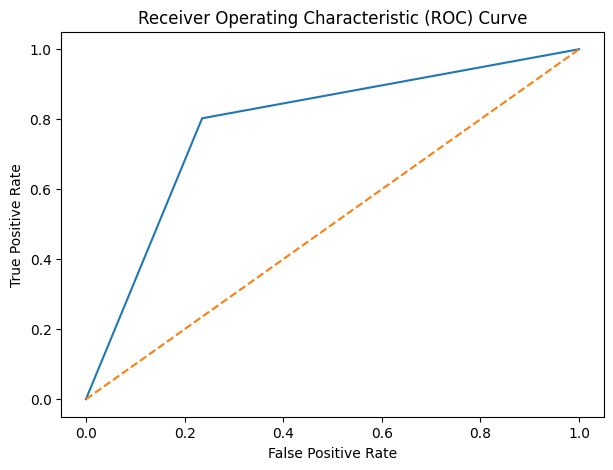

In [ ]:
plot_roc_curve(test_labels, svm_predicted)

Tune hyperparameters for SVM

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'linearsvc__C': [0.1, 1, 10],
    'linearsvc__penalty': ['l2'],
    'linearsvc__dual': [False, True],
    'linearsvc__tol': [1e-3, 1e-4, 1e-5]
}


grid_search = GridSearchCV(svm_model, param_grid, cv=5)
grid_search.fit(data, labels)

GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('tfidfvectorizer',
                                        TfidfVectorizer(ngram_range=(1, 2))),
                                       ('linearsvc',
                                        LinearSVC(C=1, max_iter=10000,
                                                  tol=0.1))]),
             param_grid={'linearsvc__C': [0.1, 1, 10],
                         'linearsvc__dual': [False, True],
                         'linearsvc__penalty': ['l2'],
                         'linearsvc__tol': [0.001, 0.0001, 1e-05]})

In [ ]:
print("Best parameters:", grid_search.best_params_)
print("Best score:", grid_search.best_score_)

Best parameters: {'linearsvc__C': 1, 'linearsvc__dual': False, 'linearsvc__penalty': 'l2', 'linearsvc__tol': 0.001}
Best score: 0.7828740536675085


# CNN from paper


1.   https://arxiv.org/pdf/1408.5882.pdf
2.   https://github.com/shagunsodhani/CNN-Sentence-Classifier/tree/master



##Downloading requirements/vector embeddings

In [28]:
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


argumentparser.py

In [29]:
from __future__ import print_function

import argparse


def ArgumentParser():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='data',
                        help='data directory containing input.txt and label.txt')
    parser.add_argument('--embedding_file_path', type=str, default='vectors.txt',
                        help='path to file for embedding vectors')
    parser.add_argument('--model_dir', type=str, default='model',
                        help='directory to store checkpointed models')
    parser.add_argument('--num_words', type=int, default=20000,
                        help='Number of words to keep from the dataset')
    parser.add_argument('--max_sequence_len', type=int, default=56,
                        help='Maximum input sequence length')
    parser.add_argument('--validation_split', type=float, default=0.2,
                        help='Fraction of data to be used for validation')
    parser.add_argument('--embedding_dim', type=int, default=100,
                        help='Dimension of the embedding space to be used')
    parser.add_argument('--model_name', type=str, default='cnn-rand',
                        help='Name of the model variant, from the CNN Sentence '
                             'Classifier paper. Possible values are cnn-rand, cnn-static'
                             'cnn-non-static. If nothing is specified, it uses the arguments'
                             'passed to the script to define the hyperparameters. To add'
                             'your own model, pass model_name as self, define your model in'
                             'app/model/model.py and invoke from model_selector function.')
    parser.add_argument('--batch_size', type=int, default=32,
                        help='minibatch size')
    parser.add_argument('--num_epochs', type=int, default=10,
                        help='number of epochs')
    parser.add_argument('--grad_clip', type=float, default=5.,
                        help='clip gradients at this value')
    parser.add_argument('--learning_rate', type=float, default=0.001,
                        help='learning rate')
    parser.add_argument('--decay_rate', type=float, default=0.0,
                        help='decay rate for rmsprop')
    # parser.add_argument('--device', type=str, default='/cpu:0',
    #                     help='Computing device to use for training. \
    #                     \'/cpu:0\' to use CPU of the machine.\
    #                     \'/gpu:0\' to use the first GPU of the machine (if there is a GPU).\
    #                     \'/gpu:1\' to use the second GPU of the machine and so on.')
    return vars(parser.parse_args())

filereader.py

In [30]:
from __future__ import division
from __future__ import print_function

import os

import numpy as np


def read_glove_vectors(glove_vector_path):
    '''Method to read glove vectors and return an embedding dict.'''
    embeddings_index = {}
    with open(glove_vector_path, 'r') as f:
        for line in f:
            values = line.strip().split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs[:]
    return embeddings_index


def read_input_data(input_data_path):
    '''Method to read data from input_data_path'''
    texts = []  # list of text samples
    labels_index = {}  # dictionary mapping label name to numeric id
    labels = []  # list of label ids
    texts = list(open(os.path.join(input_data_path, "input.txt"), "r").readlines())

    with open(os.path.join(input_data_path, "label.txt"), 'r') as label_f:
        largest_label_id = 0
        for line in label_f:
            label = str(line.strip())
            if label not in labels_index:
                labels_index[label] = largest_label_id
                largest_label_id += 1
            labels.append(labels_index[label])

    return texts, labels_index, labels

model.py

In [31]:
from __future__ import print_function

from keras.layers import Conv1D, MaxPooling1D, Embedding
from keras.layers import Dense, Input, Flatten, Dropout, Concatenate, Activation
from keras.models import Model, Sequential
from keras.optimizers import Adadelta, RMSprop, Adam


def model_selector(args, embedding_matrix):
    '''Method to select the model to be used for classification'''
    if (args.model_name.lower() != 'self'):
        return _predefined_model(args, embedding_matrix)


def _predefined_model(args, embedding_matrix):
    '''function to use one of the predefined models (based on the paper)'''
    (filtersize_list, number_of_filters_per_filtersize, pool_length_list,
     dropout_list, optimizer, use_embeddings, embeddings_trainable) \
        = _param_selector(args)

    if (use_embeddings):
        embedding_layer = Embedding(args.num_words + 1,
                                    args.embedding_dim,
                                    weights=[embedding_matrix],
                                    input_length=args.max_sequence_len,
                                    trainable=embeddings_trainable)
    else:
        embedding_layer = Embedding(args.num_words + 1,
                                    args.embedding_dim,
                                    weights=None,
                                    input_length=args.max_sequence_len,
                                    trainable=embeddings_trainable)

    print('Defining model.')

    input_node = Input(shape=(args.max_sequence_len, args.embedding_dim))
    conv_list = []
    for index, filtersize in enumerate(filtersize_list):
        nb_filter = number_of_filters_per_filtersize[index]
        pool_length = pool_length_list[index]
        conv = Conv1D(nb_filter,filtersize, activation='relu')(input_node)
        pool = MaxPooling1D(pool_size=pool_length)(conv)
        flatten = Flatten()(pool)
        conv_list.append(flatten)

    if (len(filtersize_list) > 1):
        out = Concatenate()(conv_list)
    else:
        out = conv_list[0]

    graph = Model(inputs=input_node, outputs=out)

    model = Sequential()
    model.add(embedding_layer)
    model.add(Dropout(dropout_list[0], input_shape=(args.max_sequence_len, args.embedding_dim)))
    model.add(graph)
    model.add(Dense(150))
    model.add(Dropout(dropout_list[1]))
    model.add(Activation('relu'))
    model.add(Dense(args.len_labels_index, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
                  optimizer=optimizer,
                  metrics=['acc'])
    return model


def _param_selector(args):
    '''Method to select parameters for models defined in Convolutional Neural Networks for
        Sentence Classification paper by Yoon Kim'''
    filtersize_list = [3, 4, 5]
    number_of_filters_per_filtersize = [100, 100, 100]
    pool_length_list = [2, 2, 2]
    dropout_list = [0.5, 0.5]
    #optimizer = Adadelta(lr=1, rho=0.95, epsilon=1e-06)
    optimizer = Adam(learning_rate=args.learning_rate)
    use_embeddings = True
    embeddings_trainable = False

    if (args.model_name.lower() == 'cnn-rand'):
        use_embeddings = False
        embeddings_trainable = True
    elif (args.model_name.lower() == 'cnn-static'):
        pass
    elif (args.model_name.lower() == 'cnn-non-static'):
        embeddings_trainable = True
    else:
        filtersize_list = [3, 4, 5]
        number_of_filters_per_filtersize = [150, 150, 150]
        pool_length_list = [2, 2, 2]
        dropout_list = [0.25, 0.5]
        optimizer = RMSprop(lr=args.learning_rate, decay=args.decay_rate,
                            clipvalue=args.grad_clip)
        use_embeddings = True
        embeddings_trainable = True
    return (filtersize_list, number_of_filters_per_filtersize, pool_length_list,
            dropout_list, optimizer, use_embeddings, embeddings_trainable)

train.py

In [32]:
from __future__ import print_function

import os

import numpy as np
from keras.callbacks import ModelCheckpoint
from keras.utils.data_utils import pad_sequences
from keras.preprocessing.text import Tokenizer
from keras.utils.np_utils import to_categorical

def train(args):
    print('Reading word vectors.')
    embeddings_index = read_glove_vectors(args.embedding_file_path)
    print('Found {} word vectors.'.format(len(embeddings_index)))

    print('Processing input data')
    texts, labels_index, labels = read_input_data(args.data_dir)
    # texts - list of text samples
    # labels_index - dictionary mapping label name to numeric id
    # labels - list of label ids
    print('Found {} texts.'.format(len(texts)))

    # Vectorize the text sample into 2D integer tensor
    tokenizer = Tokenizer(num_words=args.num_words)
    tokenizer.fit_on_texts(texts)
    sequences = tokenizer.texts_to_sequences(texts)
    word_index = tokenizer.word_index
    print('Found {} unique tokens.'.format(len(word_index)))

    data = pad_sequences(sequences, maxlen=args.max_sequence_len)
    print('Generated {} sequences.'.format(len(data)))

    # Transform labels to be categorical variables
    labels = to_categorical(np.asarray(labels))
    print('Shape of data tensor:', data.shape)
    print('Shape of label tensor:', labels.shape)

    # split the input data into training set and validation set
    indices = np.arange(data.shape[0])
    np.random.shuffle(indices)
    data = data[indices]
    labels = labels[indices]
    nb_validation_samples = int(args.validation_split * data.shape[0])

    x_train = data[:-nb_validation_samples]
    y_train = labels[:-nb_validation_samples]
    x_val = data[-nb_validation_samples:]
    y_val = labels[-nb_validation_samples:]
    print('Training on {} sequences.'.format(len(x_train)))

    print('Preparing embedding matrix.')

    # initiate embedding matrix with zero vectors.
    num_words = min(args.num_words, len(word_index))
    embedding_matrix = np.zeros((num_words + 1, args.embedding_dim))
    for word, i in word_index.items():
        if i > num_words:
            continue
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[i] = embedding_vector
    args.num_words = num_words
    args.len_labels_index = len(labels_index)

    model = model_selector(args, embedding_matrix)

    checkpoint_filepath = os.path.join(args.model_dir, "weights.best.hdf5")
    checkpoint = ModelCheckpoint(checkpoint_filepath, monitor='val_loss',
                                 verbose=1, save_best_only=True)
    callbacks_list = [checkpoint]
    model_json = model.to_json()
    with open(os.path.join(args.model_dir, "model.json"), "w") as json_file:
        json_file.write(model_json)

    model.fit(x_train, y_train, validation_data=(x_val, y_val),
              epochs=args.num_epochs, batch_size=args.batch_size, callbacks=callbacks_list)

https://github.com/yoonkim/CNN_sentence

In [33]:
def ArgumentParser_cnn_rand():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='data',
                        help='data directory containing input.txt and label.txt')
    parser.add_argument('--embedding_file_path', type=str, default='vectors.txt',
                        help='path to file for embedding vectors')
    parser.add_argument('--model_dir', type=str, default='model',
                        help='directory to store checkpointed models')
    parser.add_argument('--num_words', type=int, default=20000,
                        help='Number of words to keep from the dataset')
    parser.add_argument('--max_sequence_len', type=int, default=56,
                        help='Maximum input sequence length')
    parser.add_argument('--validation_split', type=float, default=0.2,
                        help='Fraction of data to be used for validation')
    parser.add_argument('--embedding_dim', type=int, default=200,
                        help='Dimension of the embedding space to be used')
    parser.add_argument('--model_name', type=str, default='cnn-rand',
                        help='Name of the model variant, from the CNN Sentence '
                             'Classifier paper. Possible values are cnn-rand, cnn-static'
                             'cnn-non-static. If nothing is specified, it uses the arguments'
                             'passed to the script to define the hyperparameters. To add'
                             'your own model, pass model_name as self, define your model in'
                             'app/model/model.py and invoke from model_selector function.')
    parser.add_argument('--batch_size', type=int, default=64,
                        help='minibatch size')
    parser.add_argument('--num_epochs', type=int, default=10,
                        help='number of epochs')
    parser.add_argument('--grad_clip', type=float, default=5.,
                        help='clip gradients at this value')
    parser.add_argument('--learning_rate', type=float, default=0.001,
                        help='learning rate')
    parser.add_argument('--decay_rate', type=float, default=0.0,
                        help='decay rate for rmsprop')
    parser.add_argument("-f", "--file", required=False) 
    # parser.add_argument('--device', type=str, default='/cpu:0',
    #                     help='Computing device to use for training. \
    #                     \'/cpu:0\' to use CPU of the machine.\
    #                     \'/gpu:0\' to use the first GPU of the machine (if there is a GPU).\
    #                     \'/gpu:1\' to use the second GPU of the machine and so on.')
    return parser.parse_args()

In [34]:
#!git clone https://github.com/shagunsodhani/CNN-Sentence-Classifier.git

In [35]:
import base64
import requests

master_input = "https://raw.githubusercontent.com/shagunsodhani/CNN-Sentence-Classifier/master/sample_dataset/input.txt"
req_input = requests.get(master_input)
req_input = req_input.text
input_list = req_input.splitlines()

master_label = "https://raw.githubusercontent.com/shagunsodhani/CNN-Sentence-Classifier/master/sample_dataset/label.txt"
req_label = requests.get(master_label)
req_label = req_label.text
label_list = req_label.splitlines()

create directory data with data

In [36]:
import os

# Create a directory called "data" if it doesn't exist already
if not os.path.exists("data"):
    os.makedirs("data")

# Create a file called "input.txt" inside the "data" directory
with open("data/input.txt", "w") as f:
    for input in input_list:
        f.write(str(input) + "\n")

# Create a file called "labels.txt" inside the "data" directory
with open("data/label.txt", "w") as f:
    for label in label_list:
        f.write(str(label) + "\n")

MR data

In [37]:
import os

# Create a directory called "data" if it doesn't exist already
if not os.path.exists("MRdata"):
    os.makedirs("MRdata")

# Create a file called "input.txt" inside the "data" directory
with open("MRdata/input.txt", "w") as f:
    print("data size: ",len(data))
    for input in data:
        f.write(str(input))

# Create a file called "labels.txt" inside the "data" directory
with open("MRdata/label.txt", "w") as f:
  print("labels size: ",len(labels))
  for label in labels:
      f.write(str(label) + "\n")

data size:  10662
labels size:  10662


In [52]:
!mkdir model

mkdir: cannot create directory ‘model’: File exists


In [54]:
!wget https://nlp.stanford.edu/data/glove.6B.zip

--2023-04-28 02:59:26--  https://nlp.stanford.edu/data/glove.6B.zip
Resolving nlp.stanford.edu (nlp.stanford.edu)... 171.64.67.140
Connecting to nlp.stanford.edu (nlp.stanford.edu)|171.64.67.140|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip [following]
--2023-04-28 02:59:26--  https://downloads.cs.stanford.edu/nlp/data/glove.6B.zip
Resolving downloads.cs.stanford.edu (downloads.cs.stanford.edu)... 171.64.64.22
Connecting to downloads.cs.stanford.edu (downloads.cs.stanford.edu)|171.64.64.22|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 862182613 (822M) [application/zip]
Saving to: ‘glove.6B.zip’

glove.6B.zip        100%[===================>] 822.24M  5.00MB/s    in 2m 39s  

2023-04-28 03:02:05 (5.19 MB/s) - ‘glove.6B.zip’ saved [862182613/862182613]



In [55]:
!mkdir glove_vectors
!unzip glove.6B.zip -d glove_vectors

mkdir: cannot create directory ‘glove_vectors’: File exists
Archive:  glove.6B.zip
  inflating: glove_vectors/glove.6B.50d.txt  
  inflating: glove_vectors/glove.6B.100d.txt  
  inflating: glove_vectors/glove.6B.200d.txt  
  inflating: glove_vectors/glove.6B.300d.txt  


In [56]:
!cp glove_vectors/glove.6B.200d.txt vectors.txt

https://code.google.com/archive/p/word2vec/ better embeddings but hard to get file

In [42]:
#!wget https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing

In [43]:
#!gdown 0B7XkCwpI5KDYNlNUTTlSS21pQmM

In [44]:
#!gunzip GoogleNews-vectors-negative300.bin.gz

## CNN Rand

In [57]:
args_rand = ArgumentParser_cnn_rand()
args_rand

Namespace(data_dir='data', embedding_file_path='vectors.txt', model_dir='model', num_words=20000, max_sequence_len=56, validation_split=0.2, embedding_dim=200, model_name='cnn-rand', batch_size=64, num_epochs=10, grad_clip=5.0, learning_rate=0.001, decay_rate=0.0, file='/root/.local/share/jupyter/runtime/kernel-75cf4a42-7d7b-48e8-abc8-c09a2619bbfc.json')

In [58]:
train(args_rand)

Reading word vectors.
Found 400000 word vectors.
Processing input data
Found 10662 texts.
Found 19498 unique tokens.
Generated 10662 sequences.
Shape of data tensor: (10662, 56)
Shape of label tensor: (10662, 2)
Training on 8530 sequences.
Preparing embedding matrix.
Defining model.
Epoch 1/10
134/134 [==============================] - ETA: 0s - loss: 0.6878 - acc: 0.5478
Epoch 1: val_loss improved from inf to 0.62058, saving model to model/weights.best.hdf5
134/134 [==============================] - 12s 15ms/step - loss: 0.6878 - acc: 0.5478 - val_loss: 0.6206 - val_acc: 0.6909
Epoch 2/10
130/134 [============================>.] - ETA: 0s - loss: 0.4712 - acc: 0.7858
Epoch 2: val_loss improved from 0.62058 to 0.48177, saving model to model/weights.best.hdf5
134/134 [==============================] - 2s 12ms/step - loss: 0.4704 - acc: 0.7860 - val_loss: 0.4818 - val_acc: 0.7692
Epoch 3/10
133/134 [============================>.] - ETA: 0s - loss: 0.1903 - acc: 0.9296
Epoch 3: val_loss 

In [60]:
def ArgumentParser_cnn_static():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='data',
                        help='data directory containing input.txt and label.txt')
    parser.add_argument('--embedding_file_path', type=str, default='vectors.txt',
                        help='path to file for embedding vectors')
    parser.add_argument('--model_dir', type=str, default='model',
                        help='directory to store checkpointed models')
    parser.add_argument('--num_words', type=int, default=20000,
                        help='Number of words to keep from the dataset')
    parser.add_argument('--max_sequence_len', type=int, default=56,
                        help='Maximum input sequence length')
    parser.add_argument('--validation_split', type=float, default=0.1,
                        help='Fraction of data to be used for validation')
    parser.add_argument('--embedding_dim', type=int, default=200,
                        help='Dimension of the embedding space to be used')
    parser.add_argument('--model_name', type=str, default='cnn-static',
                        help='Name of the model variant, from the CNN Sentence '
                             'Classifier paper. Possible values are cnn-rand, cnn-static'
                             'cnn-non-static. If nothing is specified, it uses the arguments'
                             'passed to the script to define the hyperparameters. To add'
                             'your own model, pass model_name as self, define your model in'
                             'app/model/model.py and invoke from model_selector function.')
    parser.add_argument('--batch_size', type=int, default=64,
                        help='minibatch size')
    parser.add_argument('--num_epochs', type=int, default=10,
                        help='number of epochs')
    parser.add_argument('--grad_clip', type=float, default=5.,
                        help='clip gradients at this value')
    parser.add_argument('--learning_rate', type=float, default=0.001,
                        help='learning rate')
    parser.add_argument('--decay_rate', type=float, default=0.0,
                        help='decay rate for rmsprop')
    parser.add_argument("-f", "--file", required=False) 
    # parser.add_argument('--device', type=str, default='/cpu:0',
    #                     help='Computing device to use for training. \
    #                     \'/cpu:0\' to use CPU of the machine.\
    #                     \'/gpu:0\' to use the first GPU of the machine (if there is a GPU).\
    #                     \'/gpu:1\' to use the second GPU of the machine and so on.')
    return parser.parse_args()

## CNN Static

In [61]:
args_static = ArgumentParser_cnn_static()

In [62]:
train(args_static)

Reading word vectors.
Found 400000 word vectors.
Processing input data
Found 10662 texts.
Found 19498 unique tokens.
Generated 10662 sequences.
Shape of data tensor: (10662, 56)
Shape of label tensor: (10662, 2)
Training on 9596 sequences.
Preparing embedding matrix.
Defining model.
Epoch 1/10
150/150 [==============================] - ETA: 0s - loss: 0.6973 - acc: 0.5732
Epoch 1: val_loss improved from inf to 0.57052, saving model to model/weights.best.hdf5
150/150 [==============================] - 3s 14ms/step - loss: 0.6973 - acc: 0.5732 - val_loss: 0.5705 - val_acc: 0.7233
Epoch 2/10
147/150 [============================>.] - ETA: 0s - loss: 0.5853 - acc: 0.6926
Epoch 2: val_loss improved from 0.57052 to 0.53216, saving model to model/weights.best.hdf5
150/150 [==============================] - 1s 7ms/step - loss: 0.5852 - acc: 0.6927 - val_loss: 0.5322 - val_acc: 0.7420
Epoch 3/10
144/150 [===========================>..] - ETA: 0s - loss: 0.5459 - acc: 0.7270
Epoch 3: val_loss im

In [63]:
def ArgumentParser_cnn_non_static():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='data',
                        help='data directory containing input.txt and label.txt')
    parser.add_argument('--embedding_file_path', type=str, default='vectors.txt',
                        help='path to file for embedding vectors')
    parser.add_argument('--model_dir', type=str, default='model',
                        help='directory to store checkpointed models')
    parser.add_argument('--num_words', type=int, default=20000,
                        help='Number of words to keep from the dataset')
    parser.add_argument('--max_sequence_len', type=int, default=56,
                        help='Maximum input sequence length')
    parser.add_argument('--validation_split', type=float, default=0.2,
                        help='Fraction of data to be used for validation')
    parser.add_argument('--embedding_dim', type=int, default=200,
                        help='Dimension of the embedding space to be used')
    parser.add_argument('--model_name', type=str, default='cnn-non-static',
                        help='Name of the model variant, from the CNN Sentence '
                             'Classifier paper. Possible values are cnn-rand, cnn-static'
                             'cnn-non-static. If nothing is specified, it uses the arguments'
                             'passed to the script to define the hyperparameters. To add'
                             'your own model, pass model_name as self, define your model in'
                             'app/model/model.py and invoke from model_selector function.')
    parser.add_argument('--batch_size', type=int, default=64,
                        help='minibatch size')
    parser.add_argument('--num_epochs', type=int, default=10,
                        help='number of epochs')
    parser.add_argument('--grad_clip', type=float, default=5.,
                        help='clip gradients at this value')
    parser.add_argument('--learning_rate', type=float, default=0.001,
                        help='learning rate')
    parser.add_argument('--decay_rate', type=float, default=0.0,
                        help='decay rate for rmsprop')
    parser.add_argument("-f", "--file", required=False) 
    # parser.add_argument('--device', type=str, default='/cpu:0',
    #                     help='Computing device to use for training. \
    #                     \'/cpu:0\' to use CPU of the machine.\
    #                     \'/gpu:0\' to use the first GPU of the machine (if there is a GPU).\
    #                     \'/gpu:1\' to use the second GPU of the machine and so on.')
    return parser.parse_args()

## CNN Non Static

In [64]:
args_non_static = ArgumentParser_cnn_non_static()
train(args_non_static)

Reading word vectors.
Found 400000 word vectors.
Processing input data
Found 10662 texts.
Found 19498 unique tokens.
Generated 10662 sequences.
Shape of data tensor: (10662, 56)
Shape of label tensor: (10662, 2)
Training on 8530 sequences.
Preparing embedding matrix.
Defining model.
Epoch 1/10
129/134 [===========================>..] - ETA: 0s - loss: 0.6958 - acc: 0.5768
Epoch 1: val_loss improved from inf to 0.56838, saving model to model/weights.best.hdf5
134/134 [==============================] - 3s 13ms/step - loss: 0.6925 - acc: 0.5802 - val_loss: 0.5684 - val_acc: 0.7172
Epoch 2/10
133/134 [============================>.] - ETA: 0s - loss: 0.5372 - acc: 0.7273
Epoch 2: val_loss improved from 0.56838 to 0.49943, saving model to model/weights.best.hdf5
134/134 [==============================] - 1s 10ms/step - loss: 0.5373 - acc: 0.7273 - val_loss: 0.4994 - val_acc: 0.7720
Epoch 3/10
132/134 [============================>.] - ETA: 0s - loss: 0.4313 - acc: 0.8005
Epoch 3: val_loss i

In [65]:
def ArgumentParser_cnn_multi():
    parser = argparse.ArgumentParser()
    parser.add_argument('--data_dir', type=str, default='data',
                        help='data directory containing input.txt and label.txt')
    parser.add_argument('--embedding_file_path', type=str, default='vectors.txt',
                        help='path to file for embedding vectors')
    parser.add_argument('--model_dir', type=str, default='model',
                        help='directory to store checkpointed models')
    parser.add_argument('--num_words', type=int, default=20000,
                        help='Number of words to keep from the dataset')
    parser.add_argument('--max_sequence_len', type=int, default=56,
                        help='Maximum input sequence length')
    parser.add_argument('--validation_split', type=float, default=0.2,
                        help='Fraction of data to be used for validation')
    parser.add_argument('--embedding_dim', type=int, default=200,
                        help='Dimension of the embedding space to be used')
    parser.add_argument('--model_name', type=str, default='cnn-multi',
                        help='Name of the model variant, from the CNN Sentence '
                             'Classifier paper. Possible values are cnn-rand, cnn-static'
                             'cnn-non-static. If nothing is specified, it uses the arguments'
                             'passed to the script to define the hyperparameters. To add'
                             'your own model, pass model_name as self, define your model in'
                             'app/model/model.py and invoke from model_selector function.')
    parser.add_argument('--batch_size', type=int, default=64,
                        help='minibatch size')
    parser.add_argument('--num_epochs', type=int, default=10,
                        help='number of epochs')
    parser.add_argument('--grad_clip', type=float, default=5.,
                        help='clip gradients at this value')
    parser.add_argument('--learning_rate', type=float, default=0.001,
                        help='learning rate')
    parser.add_argument('--decay_rate', type=float, default=0.0,
                        help='decay rate for rmsprop')
    parser.add_argument("-f", "--file", required=False) 
    # parser.add_argument('--device', type=str, default='/cpu:0',
    #                     help='Computing device to use for training. \
    #                     \'/cpu:0\' to use CPU of the machine.\
    #                     \'/gpu:0\' to use the first GPU of the machine (if there is a GPU).\
    #                     \'/gpu:1\' to use the second GPU of the machine and so on.')
    return parser.parse_args()

## CNN Multi channel

In [66]:
args_multi = ArgumentParser_cnn_multi()
train(args_multi)

Reading word vectors.
Found 400000 word vectors.
Processing input data
Found 10662 texts.
Found 19498 unique tokens.
Generated 10662 sequences.
Shape of data tensor: (10662, 56)
Shape of label tensor: (10662, 2)
Training on 8530 sequences.
Preparing embedding matrix.
Defining model.


/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/rmsprop.py:143: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


Epoch 1/10
134/134 [==============================] - ETA: 0s - loss: 0.7098 - acc: 0.6246
Epoch 1: val_loss improved from inf to 0.53085, saving model to model/weights.best.hdf5
134/134 [==============================] - 3s 14ms/step - loss: 0.7098 - acc: 0.6246 - val_loss: 0.5309 - val_acc: 0.7392
Epoch 2/10
129/134 [===========================>..] - ETA: 0s - loss: 0.4837 - acc: 0.7695
Epoch 2: val_loss improved from 0.53085 to 0.49774, saving model to model/weights.best.hdf5
134/134 [==============================] - 1s 10ms/step - loss: 0.4875 - acc: 0.7673 - val_loss: 0.4977 - val_acc: 0.7627
Epoch 3/10
131/134 [============================>.] - ETA: 0s - loss: 0.3675 - acc: 0.8430
Epoch 3: val_loss did not improve from 0.49774
134/134 [==============================] - 1s 9ms/step - loss: 0.3683 - acc: 0.8423 - val_loss: 0.5185 - val_acc: 0.7552
Epoch 4/10
132/134 [============================>.] - ETA: 0s - loss: 0.2525 - acc: 0.8967
Epoch 4: val_loss did not improve from 0.497

# Sentence classification with BERT

In [10]:
!pip install pytorch-nlp
!pip install pytorch-pretrained-bert

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 90.1/90.1 kB 10.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 123.8/123.8 kB 9.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 135.6/135.6 kB 18.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.7/10.7 MB 106.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.6/79.6 kB 10.6 MB/s eta 0:00:00


In [11]:
import sys
import numpy as np
import random as rn
import pandas as pd
import torch
from pytorch_pretrained_bert import BertModel
from torch import nn
# from torchnlp.datasets import imdb_dataset      # --> We are using our own uploaded dataset.
from pytorch_pretrained_bert import BertTokenizer
from tensorflow import keras 
from keras.utils import pad_sequences
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch.optim import Adam
from torch.nn.utils import clip_grad_norm_
from IPython.display import clear_output
import matplotlib.pyplot as plt
%matplotlib inline

In [12]:
rn.seed(321)
np.random.seed(321)
torch.manual_seed(321)
torch.cuda.manual_seed(321)

seperate train and test sets

In [13]:
train_texts, test_texts, train_labels, test_labels = train_test_split(data, labels, test_size=0.2, random_state=42)

reduce train and test size

In [14]:
import math

train_size = math.ceil(8000)
test_size = math.ceil(2000)

train_texts, train_labels = train_texts[:train_size], train_labels[:train_size]
test_texts, test_labels = test_texts[:test_size], test_labels[:test_size]

train_data = train_texts

print("Train size = ", train_size)

Train size =  8000


visualizing sentences lengths

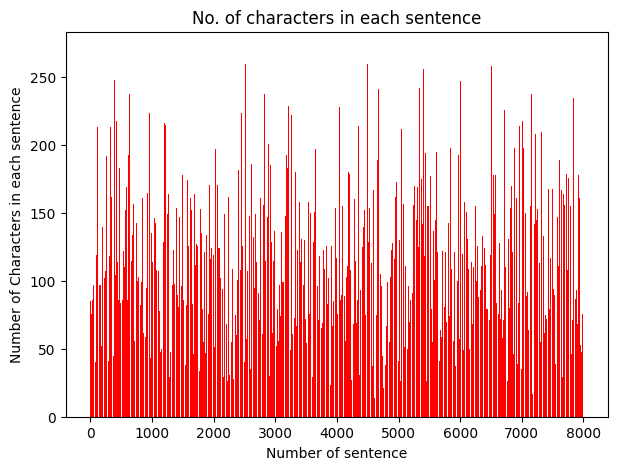

In [91]:
sentences = [len(sent) for sent in train_texts]

plt.rcParams.update({'figure.figsize':(7,5), 'figure.dpi':100})
plt.bar(range(1,len(train_data)+1), sentences, color = ['red'])
plt.gca().set(title='No. of characters in each sentence', xlabel='Number of sentence', ylabel='Number of Characters in each sentence');

In [15]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

100%|██████████| 231508/231508 [00:00<00:00, 340819.40B/s]


In [16]:
tokenizer.tokenize('Hi my name is Simo')

['hi', 'my', 'name', 'is', 'sim', '##o']

In [17]:
train_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], train_texts))
test_tokens = list(map(lambda t: ['[CLS]'] + tokenizer.tokenize(t)[:510] + ['[SEP]'], test_texts))

len(train_tokens), len(test_tokens)

(8000, 2000)

prepare token ids

In [18]:
train_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, train_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")
test_tokens_ids = pad_sequences(list(map(tokenizer.convert_tokens_to_ids, test_tokens)), maxlen=512, truncating="post", padding="post", dtype="int")

train_tokens_ids.shape, test_tokens_ids.shape

((8000, 512), (2000, 512))

In [19]:
train_y = np.array(train_labels)
test_y = np.array(test_labels)
train_y.shape, test_y.shape, np.mean(train_y), np.mean(test_y)

((8000,), (2000,), 0.502, 0.488)

Now Masking few random IDs from each sentences to remove Biasness from model.

In [20]:
train_masks = [[float(i > 0) for i in ii] for ii in train_tokens_ids]
test_masks = [[float(i > 0) for i in ii] for ii in test_tokens_ids]

In [21]:
class BertBinaryClassifier(nn.Module):
    def __init__(self, dropout=0.1):
        super(BertBinaryClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-uncased')

        self.dropout = nn.Dropout(dropout)
        self.linear = nn.Linear(768, 1)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, tokens, masks=None):
        _, pooled_output = self.bert(tokens, attention_mask=masks, output_all_encoded_layers=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        proba = self.sigmoid(linear_output)
        return proba

In [22]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cuda')

In [100]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'0.0M'

In [101]:
! nvidia-smi

Thu Apr 27 22:14:28 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   60C    P0    30W /  70W |   3043MiB / 15360MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [102]:
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run
bert_clf = BertBinaryClassifier()
bert_clf = bert_clf.cuda()     # running BERT on CUDA_GPU

100%|██████████| 407873900/407873900 [00:32<00:00, 12510455.05B/s]


In [103]:
x = torch.tensor(train_tokens_ids[:3]).to(device)
y, pooled = bert_clf.bert(x, output_all_encoded_layers=False)
x.shape, y.shape, pooled.shape

(torch.Size([3, 512]), torch.Size([3, 512, 768]), torch.Size([3, 768]))

In [104]:
y = bert_clf(x)
y.cpu().detach().numpy()  

array([[0.40782222],
       [0.41037586],
       [0.386704  ]], dtype=float32)

In [105]:
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'6272.414208M'

In [106]:
y, x, pooled = None, None, None
torch.cuda.empty_cache()     # Clearing Cache space for fresh Model run
str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'6272.414208M'

In [107]:
BATCH_SIZE = 8
EPOCHS = 10

In [108]:
train_tokens_tensor = torch.tensor(train_tokens_ids)
train_y_tensor = torch.tensor(train_y.reshape(-1, 1)).float()

test_tokens_tensor = torch.tensor(test_tokens_ids)
test_y_tensor = torch.tensor(test_y.reshape(-1, 1)).float()

train_masks_tensor = torch.tensor(train_masks)
test_masks_tensor = torch.tensor(test_masks)

str(torch.cuda.memory_allocated(device)/1000000 ) + 'M'

'6272.393216M'

In [109]:
train_dataset = TensorDataset(train_tokens_tensor, train_masks_tensor, train_y_tensor)
train_sampler = RandomSampler(train_dataset)
train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=BATCH_SIZE)

test_dataset = TensorDataset(test_tokens_tensor, test_masks_tensor, test_y_tensor)
test_sampler = SequentialSampler(test_dataset)
test_dataloader = DataLoader(test_dataset, sampler=test_sampler, batch_size=BATCH_SIZE)

In [110]:
param_optimizer = list(bert_clf.sigmoid.named_parameters()) 
optimizer_grouped_parameters = [{"params": [p for n, p in param_optimizer]}]

In [111]:
optimizer = Adam(bert_clf.parameters(), lr=3e-6)

In [112]:
torch.cuda.empty_cache()   # Clearing Cache space for a fresh Model run

##Train Bert

In [113]:
for epoch_num in range(EPOCHS):
    bert_clf.train()
    train_loss = 0
    for step_num, batch_data in enumerate(train_dataloader):
        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)
        print(str(torch.cuda.memory_allocated(device)/1000000 ) + 'M')
        logits = bert_clf(token_ids, masks)
        
        loss_func = nn.BCELoss()

        batch_loss = loss_func(logits, labels)
        train_loss += batch_loss.item()
        
        
        bert_clf.zero_grad()
        batch_loss.backward()
        

        clip_grad_norm_(parameters=bert_clf.parameters(), max_norm=1.0)
        optimizer.step()
        
        clear_output(wait=True)
        print('Epoch: ', epoch_num + 1)
        print("\r" + "{0}/{1} loss: {2} ".format(step_num, len(train_data) / BATCH_SIZE, train_loss / (step_num + 1)))


Epoch:  10
999/1000.0 loss: 0.050909964466380186 


##Evaluate bert

In [114]:
bert_clf.eval()
bert_predicted = []
all_logits = []
with torch.no_grad():
    for step_num, batch_data in enumerate(test_dataloader):

        token_ids, masks, labels = tuple(t.to(device) for t in batch_data)

        logits = bert_clf(token_ids, masks)
        loss_func = nn.BCELoss()
        loss = loss_func(logits, labels)
        numpy_logits = logits.cpu().detach().numpy()
        
        bert_predicted += list(numpy_logits[:, 0] > 0.5)
        all_logits += list(numpy_logits[:, 0])

In [115]:
np.mean(bert_predicted)

0.5375

In [23]:
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
print(classification_report(test_y, bert_predicted))
print("Accuracy: " + str(accuracy_score(test_y, bert_predicted)))

NameError: ignored